In [1]:
# Installing Comet
!pip install comet_ml

import comet_ml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
my_api_key = user_secrets.get_secret("COMET_API_KEY")

## import comet_ml at the top of your file
from comet_ml import Experiment

## Create an experiment with your api key
experiment = Experiment(
    api_key= my_api_key,
    project_name="experiment-tracking-pytorch-3",
    workspace="tirendaz-test",
)

hyper_params = {"batch_size": 32, "num_epochs": 5, "learning_rate": 0.001,"hidden_unit": 128, "image_size": 128}
experiment.log_parameters(hyper_params)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.9/450.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.4/504.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/tirendaz-test/experiment-tracking-pytorch-3/83e6ea947e674e278d865218ec356b86



Random image path: /kaggle/input/cat-and-dog/test_set/test_set/cats/cat.4202.jpg
Image class: cats
Image height: 217
Image width: 179


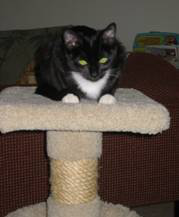

In [2]:
import random
from PIL import Image
import glob
from pathlib import Path

image_path = "/kaggle/input/cat-and-dog"
train_dir = f"{image_path}/training_set/training_set"
test_dir = f"{image_path}/test_set/test_set"

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [3]:
IMAGE_WIDTH=hyper_params['image_size']
IMAGE_HEIGHT=hyper_params['image_size']
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
     transforms.Normalize(
         [0.485, 0.456,0.406],  
         [0.229, 0.224, 0.225])  
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
         [0.485, 0.456,0.406],  
         [0.229, 0.224, 0.225])  
])

In [4]:
import os

# Turn image folders into Datasets
train_data= datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader = DataLoader(train_data,
                              batch_size=hyper_params['batch_size'], 
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                             batch_size=hyper_params['batch_size'], 
                             shuffle=False, 
                             num_workers=NUM_WORKERS)

In [5]:
class CNNImageClassifier(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(hidden_units),
          nn.MaxPool2d(2)
          ) 
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(hidden_units),
          nn.MaxPool2d(2)
          ) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.conv_layer_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x

torch.manual_seed(42)
model = CNNImageClassifier(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=hyper_params['hidden_unit'], 
                  output_shape=len(train_data.classes)).to(device)

In [6]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

# do a test pass through of an example input size 
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT]) 

Layer (type:depth-idx)                   Output Shape              Param #
CNNImageClassifier                       [1, 2]                    --
├─Sequential: 1-1                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [1, 128, 128, 128]        3,584
│    └─ReLU: 2-2                         [1, 128, 128, 128]        --
│    └─BatchNorm2d: 2-3                  [1, 128, 128, 128]        256
│    └─MaxPool2d: 2-4                    [1, 128, 64, 64]          --
├─Sequential: 1-2                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─BatchNorm2d: 2-7                  [1, 128, 64, 64]          256
│    └─MaxPool2d: 2-8                    [1, 128, 32, 32]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          (recursive)
│    └─Conv2d: 2-9                       [1, 128, 32, 32]         

In [7]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    experiment.log_metrics({"train_accuracy": train_acc, "train_loss": train_loss}, epoch=hyper_params['num_epochs'])
    return train_loss, train_acc

In [8]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    experiment.log_metrics({"test_accuracy": test_acc, "test_loss": test_loss}, epoch=hyper_params['num_epochs'])
    return test_loss, test_acc

In [9]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(hyper_params['num_epochs'])):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [10]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=hyper_params['learning_rate'])

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn, 
                      epochs=hyper_params['num_epochs'])

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7667 | train_acc: 0.5941 | test_loss: 0.6083 | test_acc: 0.6676
Epoch: 2 | train_loss: 0.6821 | train_acc: 0.6415 | test_loss: 0.6603 | test_acc: 0.6651
Epoch: 3 | train_loss: 0.6284 | train_acc: 0.6740 | test_loss: 0.5493 | test_acc: 0.7196
Epoch: 4 | train_loss: 0.5973 | train_acc: 0.6933 | test_loss: 0.6107 | test_acc: 0.7093
Epoch: 5 | train_loss: 0.5553 | train_acc: 0.7284 | test_loss: 0.4845 | test_acc: 0.7706
Total training time: 303.850 seconds


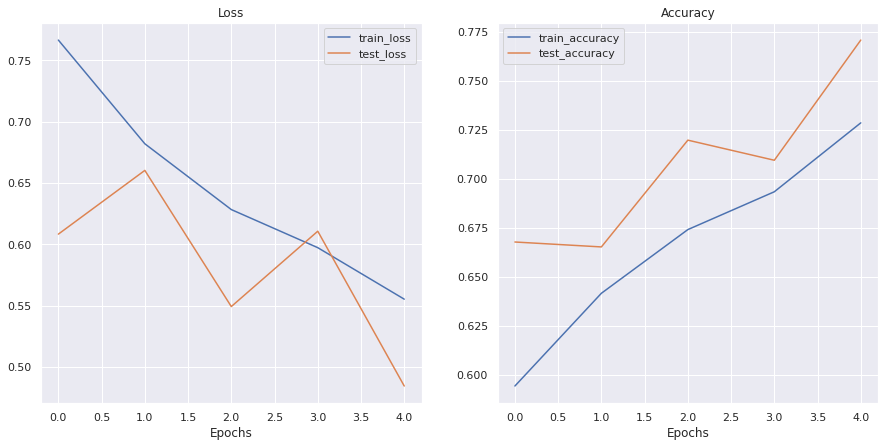

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
plot_loss_curves(model_results)

In [12]:
# Save the model for inference
from comet_ml.integration.pytorch import log_model
log_model(experiment, model, model_name="My_Model")

In [13]:
# Choose a image.
custom_image_path = "/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))
    

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

class_names = train_data.classes
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'dogs'

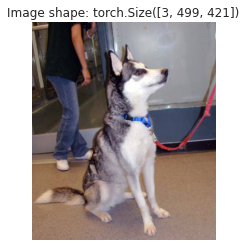

In [14]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [15]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tirendaz-test/experiment-tracking-pytorch-3/83e6ea947e674e278d865218ec356b86
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [126]         : (0.3402763903141022, 1.4224852323532104)
COMET INFO:     test_accuracy [5]  : (0.6651088169642857, 0.7706473214285714)
COMET INFO:     test_loss [5]      : (0.48446191172115505, 0.6603429233655334)
COMET INFO:     train_accuracy [5] : (0.594148406374502, 0.7284113545816734)
COMET INFO:     train_loss [5]     : (0.5552971184372427, 0.7666507542608268)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     hidden_unit   : 128
COMET INFO:     image_size    : 128
COMET INFO:     learning_rate : 0.001
COMET INFO:     num_epochs    : 5
COMET INFO:   Uploads:
COMET INFO:     con

- Thank you for reading 😀 If you like this notebook, don't forget to upvote it 😊

- Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) |[GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎